In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
from matplotlib.collections import LineCollection

In [3]:
# --- 1. Load Data ---
# Load the telemetry data
df = pd.read_csv('../telemetry/human_best_run.csv')

# Load the checkpoint data (for the map overlay)
with open('../assets/SimpleTrackCP/SimpleTrack_checkpoints.json', 'r') as f:
    cp_data = json.load(f)

In [ ]:
# --- 2. Data Processing & Rotation Fix ---
# Parse steering
def parse_steering(cmd):
    if not isinstance(cmd, str): return 0
    if 'push right' in cmd: return 1
    if 'push left' in cmd: return -1
    return 0

df['steering_val'] = df['input_cmd'].apply(parse_steering)

# TRANSFORM CHECKPOINTS TO MATCH WORLD ROTATION (-90 deg)
raw_x = np.array([cp['position'][0] for cp in cp_data['checkpoints']])
raw_y = np.array([cp['position'][1] for cp in cp_data['checkpoints']])

# Apply track.py logic: Local = (-JSON_X, -JSON_Y)
# Then rotate -90 deg: New_X = Local_Z, New_Z = -Local_X
# So: New_X = -JSON_Y, New_Z = -(-JSON_X) = JSON_X
# Transformation: Rotate 90 deg the other way
cp_x = raw_y        # Maps -400..0 -> -400..0 (Matches Car X)
cp_z = -raw_x       # Maps 0..300 -> 0..-300 (Matches Car Z)

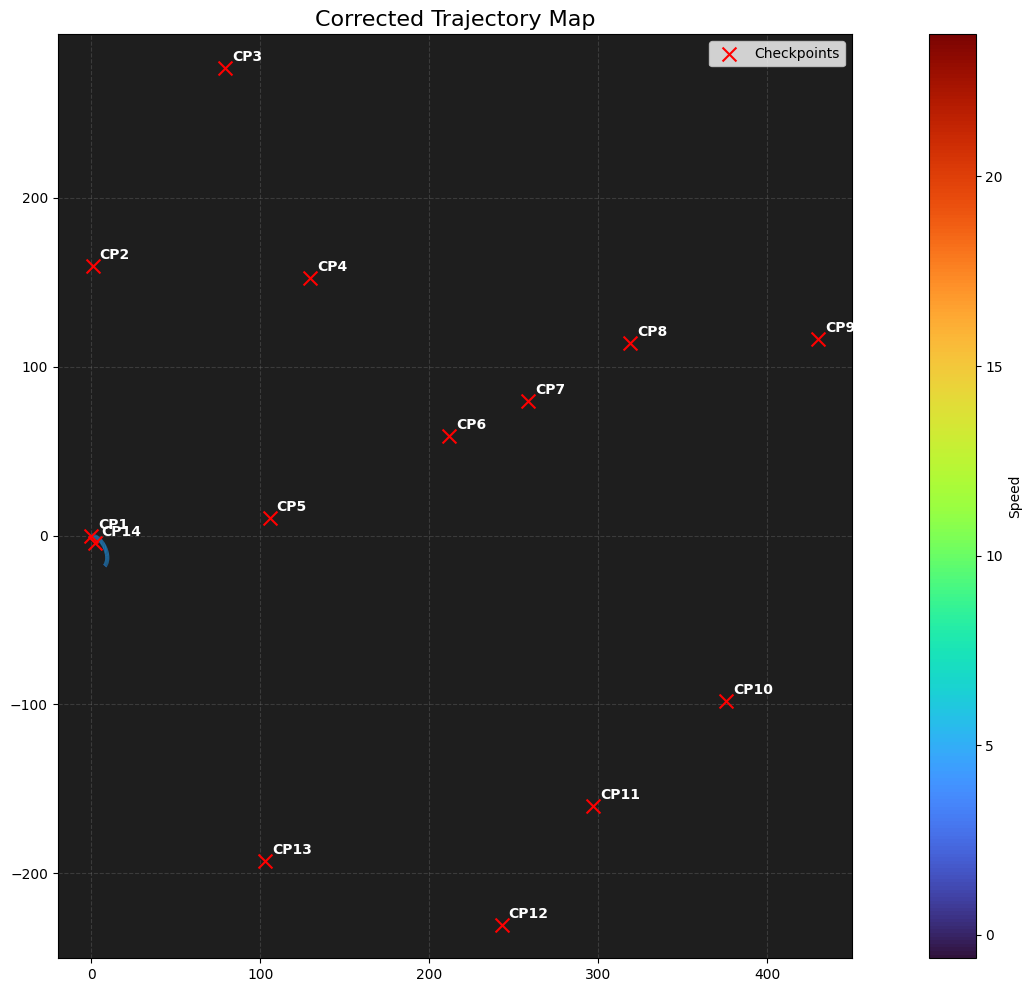

In [9]:
# --- 3. Plotting ---
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1) # Focus just on the map for now

# Create colored line for speed
points = np.array([df['pos_x'], df['pos_z']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(df['speed'].min(), df['speed'].max())
lc = LineCollection(segments, cmap='turbo', norm=norm, linewidth=3)
line = ax1.add_collection(lc)

# Overlay Checkpoints
ax1.scatter(cp_x, cp_z, c='red', marker='x', s=100, label='Checkpoints', zorder=5)
for i, (x, z) in enumerate(zip(cp_x, cp_z)):
    ax1.annotate(f"CP{i+1}", (x, z), xytext=(5, 5), textcoords='offset points', color='white', fontweight='bold')

# Auto-scale to fit EVERYTHING (Car + Checkpoints)
all_x = np.concatenate([df['pos_x'], cp_x])
all_z = np.concatenate([df['pos_z'], cp_z])
ax1.set_xlim(all_x.min() - 20, all_x.max() + 20)
ax1.set_ylim(all_z.min() - 20, all_z.max() + 20)

ax1.set_aspect('equal')
ax1.set_facecolor('#1e1e1e')
ax1.grid(color='gray', linestyle='--', alpha=0.3)
ax1.set_title(f"Corrected Trajectory Map", fontsize=16)
plt.colorbar(line, ax=ax1, label="Speed")
plt.legend()
plt.show()